In [1]:
import numpy as np
from mat73 import loadmat
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_all = loadmat("data_all.mat")["data_all"] # load the matfile

In [3]:
nsol = data_all["err"].size # number of pre-trained solutions
nc = 4 # number of cell types in a subnetwork, excluding L4 feedforward input
nb = 4 # number of interconnected subnetworks
nc2 = nc * nb # total number of units, excluding L4 feedforward input
is0 = 1 # select center stimulus (from dim. 3 of X, others are likely cross, iso, and blank?) with Pythonic index

nco = 11 # number of contrasts
contrast_c = np.linspace(0, 1, nco) # linearly spaced contrasts from 0 to 1

new_max = 1 # maximum activity allowed, otherwise classified as unstable

Response to Center Stimulus under Control Conditions

Contrast #0


  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:00<00:00, 668.63it/s]


Contrast #1


100%|██████████| 115/115 [00:00<00:00, 608.45it/s]


Contrast #2


100%|██████████| 115/115 [00:00<00:00, 629.76it/s]


Contrast #3


100%|██████████| 115/115 [00:00<00:00, 586.03it/s]


Contrast #4


100%|██████████| 115/115 [00:00<00:00, 587.16it/s]


Contrast #5


100%|██████████| 115/115 [00:00<00:00, 571.24it/s]


Contrast #6


100%|██████████| 115/115 [00:00<00:00, 537.35it/s]


Contrast #7


100%|██████████| 115/115 [00:00<00:00, 454.00it/s]


Contrast #8


100%|██████████| 115/115 [00:00<00:00, 460.92it/s]


Contrast #9


100%|██████████| 115/115 [00:00<00:00, 426.26it/s]


Contrast #10


100%|██████████| 115/115 [00:00<00:00, 11950.47it/s]


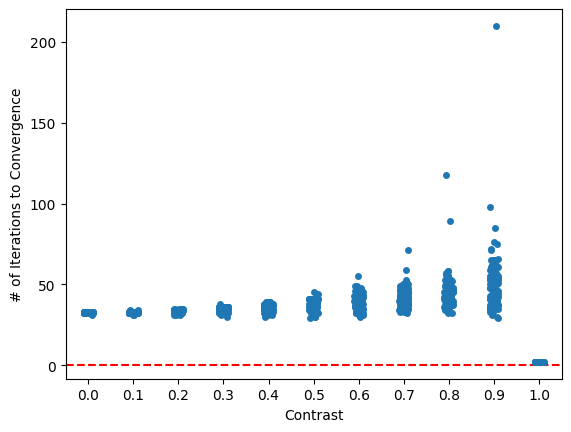

In [4]:
fixed_points = np.tile(np.nan, (nsol, nco, nc2)) # store fixed points (after convergence) for each model solution, contrast, and unit
num_iters = np.zeros((nsol, nco))
dynpars = data_all["dynpars"] # grab model training parameters
for ico in range(nco):
    print("Contrast #{0}".format(ico))
    cc = contrast_c[ico] # get the current contrast value
    for isol in tqdm(range(nsol)):
        rt = np.expand_dims(data_all["X"][isol, :nc2, is0].squeeze(), axis=0) # starting activity for each unit, excluding L4 input
        h = cc * data_all["X"][isol, nc2:, is0].squeeze() # L4 feedforward input, scaled by current contrast value
        W = data_all["W"][isol, :, :].squeeze()
        #### simulate until timeout, convergence, or unstable
        dr = 1 # change in the rate
        it = 0 # number of iterations
        while (it < dynpars["nt"]) & (dr > dynpars["eps_dr"]) & (rt.max() < new_max):
            r0 = rt[it, :] # get current starting point (last activity vector)
            a = np.concatenate((r0, h)) # tack L4 units onto the rest for multiplication with W
            ## compute the new activity vector by adding the change (flowing through the subnetwork) to the starting point 
            r1 = r0 + (-r0 + np.maximum(np.matmul(W, a), 0)**2) * dynpars["dt"]
            rt = np.vstack((rt, r1)) # store the new activity vector
            dr = np.sum((r1 - r0)**2) # compute the change from previous activity vector
            it += 1
        fixed_points[isol, ico, :] = r1
        num_iters[isol, ico] = it + 1
# plot the number of iterations to reach convergence for each contrast
iter_df = pd.DataFrame(num_iters, columns=[np.round(c, 2) for c in contrast_c])
iter_df = iter_df.melt(var_name='Contrast', value_name='# of Iterations to Convergence')
sns.stripplot(x='Contrast', y='# of Iterations to Convergence', data=iter_df)
plt.axhline(0, color="r", linestyle="--")

Response to Center Stimulus during Optogenetic Perturbation of PV and VIP

In [5]:
doo = 0.05 # optogenetic stimulus strength
r_opto = {"PV" : np.tile(np.nan, (nco, nc2, nsol)), 
          "VIP" : np.tile(np.nan, (nco, nc2, nsol))} # store activity for each perturbation
time_steps = {"PV" : np.tile(np.nan, (nco, nsol)), 
              "VIP" : np.tile(np.nan, (nco, nsol))} # store iteration counts for each perturbation 
opto_idx = {"PV" : 1, "VIP" : 3} # Pythonic PV and VIP indices within weight matrix
dynpars = data_all["dynpars"] # grab model training parameters
for ico in range(nco):
    print("Contrast #{0}".format(ico))
    cc = contrast_c[ico] # get the current contrast value
    for ct in ["PV", "VIP"]:
        Wo = np.zeros((nc,)) # subnetwork
        Wo[opto_idx[ct]] = 1 # opto stimulation for current cell type
        Wo = np.tile(Wo, (nb,)) # tile for each subnetwork
        Oh = Wo * doo # scale opto input by stimulus strength
        for isol in tqdm(range(nsol)):
            rt = np.expand_dims(data_all["X"][isol, :nc2, is0].squeeze(), axis=0) # starting activity for each unit, excluding L4 input
            h = cc * data_all["X"][isol, nc2:, is0].squeeze() # L4 feedforward input, scaled by current contrast value
            W = data_all["W"][isol, :, :].squeeze()
            #### simulate until timeout, convergence, or unstable
            dr = 1 # change in the rate
            it = 0 # number of iterations
            while (it < dynpars["nt"]) & (dr > dynpars["eps_dr"]) & (rt.max() < new_max):
                r0 = rt[it, :] # get current starting point (last activity vector)
                a = np.concatenate((r0, h)) # tack L4 units onto the rest for multiplication with W
                ## compute the new activity vector by adding the change (flowing through the subnetwork) to the starting point
                r1 = r0 + (-r0 + np.maximum(np.matmul(W, a) + Oh, 0)**2) * dynpars["dt"] # add opto stimulation (Oh)
                rt = np.vstack((rt, r1)) # store the new activity vector
                dr = np.sum((r1 - r0)**2) # compute the change from previous activity vector
                it += 1
            #### store activity if solutions did not time out and are still stable
            if (it < dynpars["nt"]) & (rt.max() < dynpars["max_x"]):
                r_opto[ct][ico, :, isol] = r1
            time_steps[ct][ico, isol] = it # store # of iterations in any case
check_nan = lambda x: np.all(np.isnan(x[:, 0, :]) == False, axis=0)
sol_exist = np.where(check_nan(r_opto["PV"]) & check_nan(r_opto["VIP"]))[0]

Contrast #0


100%|██████████| 115/115 [00:00<00:00, 598.41it/s]


Contrast #1


100%|██████████| 115/115 [00:00<00:00, 588.73it/s]


Contrast #2


100%|██████████| 115/115 [00:00<00:00, 592.24it/s]


Contrast #3


100%|██████████| 115/115 [00:00<00:00, 587.74it/s]


Contrast #4


100%|██████████| 115/115 [00:00<00:00, 527.80it/s]


Contrast #5


100%|██████████| 115/115 [00:00<00:00, 512.70it/s]


Contrast #6


100%|██████████| 115/115 [00:00<00:00, 488.80it/s]


Contrast #7


100%|██████████| 115/115 [00:00<00:00, 433.89it/s]


Contrast #8


100%|██████████| 115/115 [00:00<00:00, 336.61it/s]


Contrast #9


100%|██████████| 115/115 [00:00<00:00, 287.41it/s]


Contrast #10


100%|██████████| 115/115 [00:00<00:00, 950.25it/s]


/var/folders/q9/55ddr8ls05q0zp9f1rrcsj1h0000gn/T/ipykernel_70227/1691204171.py:9: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(np.log10(contrast_c), np.log10(control), color="black")
/var/folders/q9/55ddr8ls05q0zp9f1rrcsj1h0000gn/T/ipykernel_70227/1691204171.py:10: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(np.log10(contrast_c), np.log10(pv_stim), color="blue")
/var/folders/q9/55ddr8ls05q0zp9f1rrcsj1h0000gn/T/ipykernel_70227/1691204171.py:11: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(np.log10(contrast_c), np.log10(vip_stim), color="green")


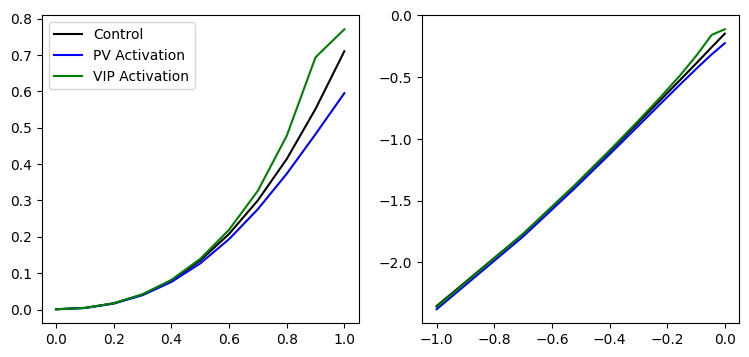

In [6]:
control = np.mean(fixed_points[sol_exist, :, 0], axis=0)
pv_stim = np.mean(r_opto["PV"][:, 0, sol_exist], axis=1)
vip_stim = np.mean(r_opto["VIP"][:, 0, sol_exist], axis=1)

fig, axs = plt.subplots(1, 2)
axs[0].plot(contrast_c, control, color="black")
axs[0].plot(contrast_c, pv_stim, color="blue")
axs[0].plot(contrast_c, vip_stim, color="green")
axs[1].plot(np.log10(contrast_c), np.log10(control), color="black")
axs[1].plot(np.log10(contrast_c), np.log10(pv_stim), color="blue")
axs[1].plot(np.log10(contrast_c), np.log10(vip_stim), color="green")
axs[0].legend(("Control", "PV Activation", "VIP Activation"))
fig.set_size_inches(9, 4)

Reproduce Figure S4

In [7]:
#### get iso fixed points
is0 = 2 # select fixed point (blank, center, iso, cross)
iso_fixed_points = np.tile(np.nan, (nsol, nc2)) # store fixed points (after convergence) for each model solution, contrast, and unit
num_iters = np.zeros((nsol))
dynpars = data_all["dynpars"] # grab model training parameters
for isol in tqdm(range(nsol)):
    rt = np.expand_dims(data_all["X"][isol, :nc2, is0].squeeze(), axis=0) # starting activity for each unit, excluding L4 input
    h = data_all["X"][isol, nc2:, is0].squeeze() # L4 feedforward input, scaled by current contrast value
    W = data_all["W"][isol, :, :].squeeze()
    #### simulate until timeout, convergence, or unstable
    dr = 1 # change in the rate
    it = 0 # number of iterations
    while (it < dynpars["nt"]) & (dr > dynpars["eps_dr"]) & (rt.max() < new_max):
        r0 = rt[it, :] # get current starting point (last activity vector)
        a = np.concatenate((r0, h)) # tack L4 units onto the rest for multiplication with W
        ## compute the new activity vector by adding the change (flowing through the subnetwork) to the starting point 
        r1 = r0 + (-r0 + np.maximum(np.matmul(W, a), 0)**2) * dynpars["dt"]
        rt = np.vstack((rt, r1)) # store the new activity vector
        dr = np.sum((r1 - r0)**2) # compute the change from previous activity vector
        it += 1
    iso_fixed_points[isol, :] = r1
    num_iters[isol] = it + 1

100%|██████████| 115/115 [00:00<00:00, 11114.45it/s]


In [46]:
data_all.keys()

dict_keys(['CMI', 'W', 'W_flat', 'W_mask', 'W_mod', 'W_tr', 'X', 'X_data_e', 'X_data_m', 'Xopto', 'Xopto_small', 'acos_theta', 'check_l4', 'check_l4_12', 'delta_CMI', 'dynpars', 'err', 'exp_id', 'rate_factor'])

100%|██████████| 115/115 [00:00<00:00, 7692.29it/s]


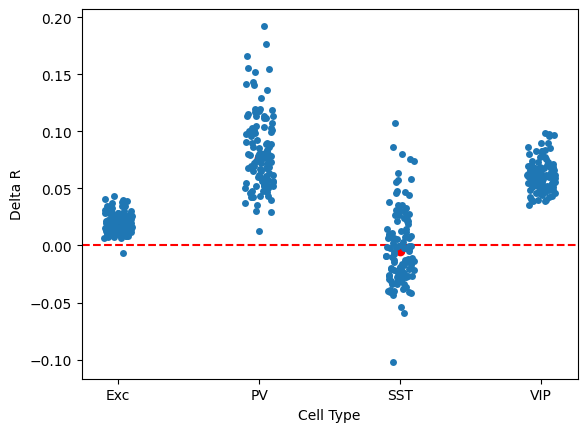

In [42]:
I = np.identity(nc2)
n = 2
opto_idx = {"VIP" : 3} # Pythonic PV and VIP indices within weight matrix
dq = 0.01

r_opto = {"VIP" : np.tile(np.nan, (nc2, nsol))} # store activity for each perturbation

for ct in ["VIP"]:
    p = np.zeros((nc,)) # subnetwork
    p[opto_idx[ct]] = 1 # opto stimulation for current cell type
    p = np.tile(p, (nb,)) # tile for each subnetwork
    for isol in tqdm(range(nsol)):
        rt = iso_fixed_points[isol, :]
        d = n * (rt ** (1 - 1/n))
        D = np.diag(d)
        A = data_all["W"][isol, :, :nc2].squeeze()
        dr = np.matmul(np.linalg.inv(I - np.matmul(D, A)), np.matmul(D, p * dq))
        r_opto[ct][:, isol] = dr

subnetwork = r_opto["VIP"][:4, :].T * data_all["rate_factor"][:4]
# plot the perturbation for each cell type in centered, preferred direction subnetwork
dr_df = pd.DataFrame(subnetwork, columns=["Exc", "PV", "SST", "VIP"])
dr_df = dr_df.melt(var_name='Cell Type', value_name='Delta R')
sns.stripplot(x='Cell Type', y='Delta R', data=dr_df)
# dr_med_df = pd.DataFrame(np.median(subnetwork), columns=["Exc", "PV", "SST", "VIP"])
# sns.stripplot(x='Cell Type', y='Delta R', data=dr_df)
plt.plot(np.median(subnetwork, axis=0), 'o', color="red")
plt.axhline(0, color="r", linestyle="--")

# fig, ax = plt.subplots()
# ax.plot(subnetwork, 'o')
# ax.



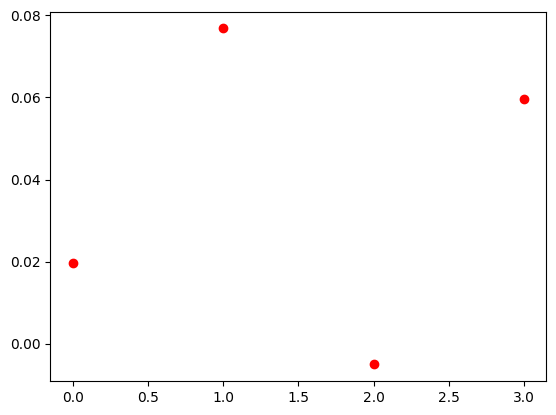

In [43]:
plt.plot(np.median(subnetwork, axis=0), 'o', color="red")

Perturb VIP and PV using Linearized Dynamics

Contrast #0


100%|██████████| 115/115 [00:00<00:00, 12268.10it/s]


Contrast #1


100%|██████████| 115/115 [00:00<00:00, 9800.57it/s]


Contrast #2


100%|██████████| 115/115 [00:00<00:00, 8442.79it/s]


Contrast #3


100%|██████████| 115/115 [00:00<00:00, 10592.37it/s]


Contrast #4


100%|██████████| 115/115 [00:00<00:00, 10429.08it/s]


Contrast #5


100%|██████████| 115/115 [00:00<00:00, 5529.13it/s]


Contrast #6


100%|██████████| 115/115 [00:00<00:00, 7799.26it/s]


Contrast #7


100%|██████████| 115/115 [00:00<00:00, 7252.22it/s]


Contrast #8


100%|██████████| 115/115 [00:00<00:00, 7027.17it/s]


Contrast #9


100%|██████████| 115/115 [00:00<00:00, 7127.79it/s]


Contrast #10


100%|██████████| 115/115 [00:00<00:00, 7366.07it/s]
/var/folders/q9/55ddr8ls05q0zp9f1rrcsj1h0000gn/T/ipykernel_70227/734460763.py:35: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(np.log10(contrast_c), np.log10(control), color="black")
/var/folders/q9/55ddr8ls05q0zp9f1rrcsj1h0000gn/T/ipykernel_70227/734460763.py:36: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(np.log10(contrast_c), np.log10(pv_stim), color="blue")
/var/folders/q9/55ddr8ls05q0zp9f1rrcsj1h0000gn/T/ipykernel_70227/734460763.py:37: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(np.log10(contrast_c), np.log10(vip_stim), color="green")


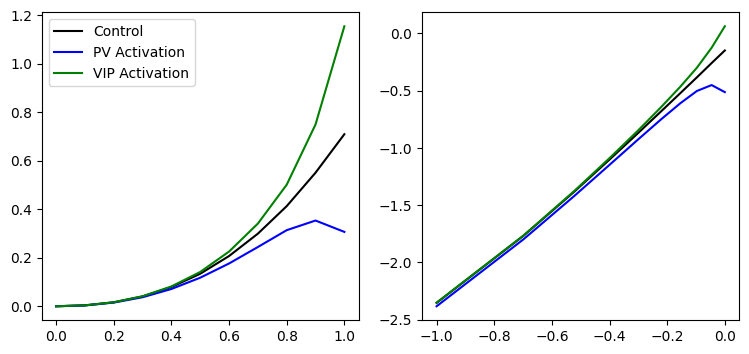

In [47]:
is0 = 1 # select fixed point (blank, center, iso, cross)

I = np.identity(nc2)
n = 2
opto_idx = {"PV" : 1, "VIP" : 3} # Pythonic PV and VIP indices within weight matrix
dq = 0.1

r_opto = {"PV" : np.tile(np.nan, (nco, nc2, nsol)), 
          "VIP" : np.tile(np.nan, (nco, nc2, nsol))} # store activity for each perturbation
for ico in range(nco):
    print("Contrast #{0}".format(ico))
    cc = contrast_c[ico] # get the current contrast value
    for ct in ["PV", "VIP"]:
        p = np.zeros((nc,)) # subnetwork
        p[opto_idx[ct]] = 1 # opto stimulation for current cell type
        p = np.tile(p, (nb,)) # tile for each subnetwork
        for isol in tqdm(range(nsol)):
            rt = fixed_points[isol, ico, :]
            d = n * (rt ** (1 - 1/n))
            D = np.diag(d)
            A = data_all["W"][isol, :, :nc2].squeeze()
            dr = np.matmul(np.linalg.inv(I - np.matmul(D, A)), np.matmul(D, p*dq))
            r_opto[ct][ico, :, isol] = dr

pv_change = np.mean(r_opto["PV"][:, 0, :], axis=1)
vip_change = np.mean(r_opto["VIP"][:, 0, :], axis=1)
control = np.mean(fixed_points[sol_exist, :, 0], axis=0)
pv_stim = control + pv_change
vip_stim = control + vip_change

fig, axs = plt.subplots(1, 2)
axs[0].plot(contrast_c, control, color="black")
axs[0].plot(contrast_c, pv_stim, color="blue")
axs[0].plot(contrast_c, vip_stim, color="green")
axs[1].plot(np.log10(contrast_c), np.log10(control), color="black")
axs[1].plot(np.log10(contrast_c), np.log10(pv_stim), color="blue")
axs[1].plot(np.log10(contrast_c), np.log10(vip_stim), color="green")
axs[0].legend(("Control", "PV Activation", "VIP Activation")) # "Control",
fig.set_size_inches(9, 4)